# **TSLA Stock XGBoost Model**

In [57]:
!pip install shap

86315.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [58]:
import shap
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [59]:
TSLA = pd.read_csv('TSLA_Final_Dataset.csv')

In [60]:
X = TSLA.drop(['Adj Close', 'Close', 'Date'], axis=1)  # Features
y = TSLA['Adj Close']  # Target variable

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [62]:
base_model = xgb.XGBRegressor()

In [63]:
base_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [64]:
y_pred = base_model.predict(X_test)
df_pred = pd.DataFrame(y_pred, columns=['Predicted'])
df_pred

,Predicted
0,47.746437
1,192.482712
2,98.210976
3,201.979660
4,221.984055
...,...
246,148.993195
247,194.489334
248,216.614410
249,236.164093


In [65]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 25.43928240545601


In [66]:
import numpy as np

# Get feature importances from the trained model
feature_importances = base_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances * 100})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
1,High,82.226044
2,Low,15.124446
0,Open,1.595180
10,SMA_20,0.488186
12,EMA_12,0.370387
13,EMA_26,0.082918
9,stock_return,0.024076
20,F Yest_Close,0.013107
18,GM Yest_Close,0.010019
8,Yest_Close,0.008784


In [67]:
# Select the top k significant features
k = 10  # Number of significant features to select
significant_features = feature_importance_df.head(k)['Feature'].values

# Filter the data to keep only the significant features
X_significant_training = X_train[significant_features]
X_significant_testing = X_test[significant_features]

In [68]:
# Retrain the model using only the significant features
model_retrained = xgb.XGBRegressor()
model_retrained.fit(X_significant_training, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [69]:
y_pred_retrained = model_retrained.predict(X_significant_testing)
df_pred_retrained = pd.DataFrame(y_pred_retrained, columns=['Optimized Predicted'])
df_pred_retrained

,Optimized Predicted
0,47.242542
1,189.050980
2,98.171661
3,200.596390
4,228.704803
...,...
246,149.782913
247,193.016846
248,216.648300
249,237.266846


In [70]:
mse = mean_squared_error(y_test, y_pred_retrained)
print("Mean Squared Error:", mse)

Mean Squared Error: 20.622600930751016


In [71]:
df_test = pd.DataFrame(y_test, columns=['Adj Close'])
df_test.reset_index(drop=True, inplace=True)
df_test

,Adj Close
0,45.781334
1,191.300003
2,99.001335
3,205.533340
4,233.000000
...,...
246,147.433334
247,191.809998
248,213.446671
249,235.940002


In [72]:
# Concatenate the dataframes horizontally
merged_df = pd.concat([df_test, df_pred, df_pred_retrained], axis=1)
merged_df

,Adj Close,Predicted,Optimized Predicted
0,45.781334,47.746437,47.242542
1,191.300003,192.482712,189.050980
2,99.001335,98.210976,98.171661
3,205.533340,201.979660,200.596390
4,233.000000,221.984055,228.704803
...,...,...,...
246,147.433334,148.993195,149.782913
247,191.809998,194.489334,193.016846
248,213.446671,216.614410,216.648300
249,235.940002,236.164093,237.266846


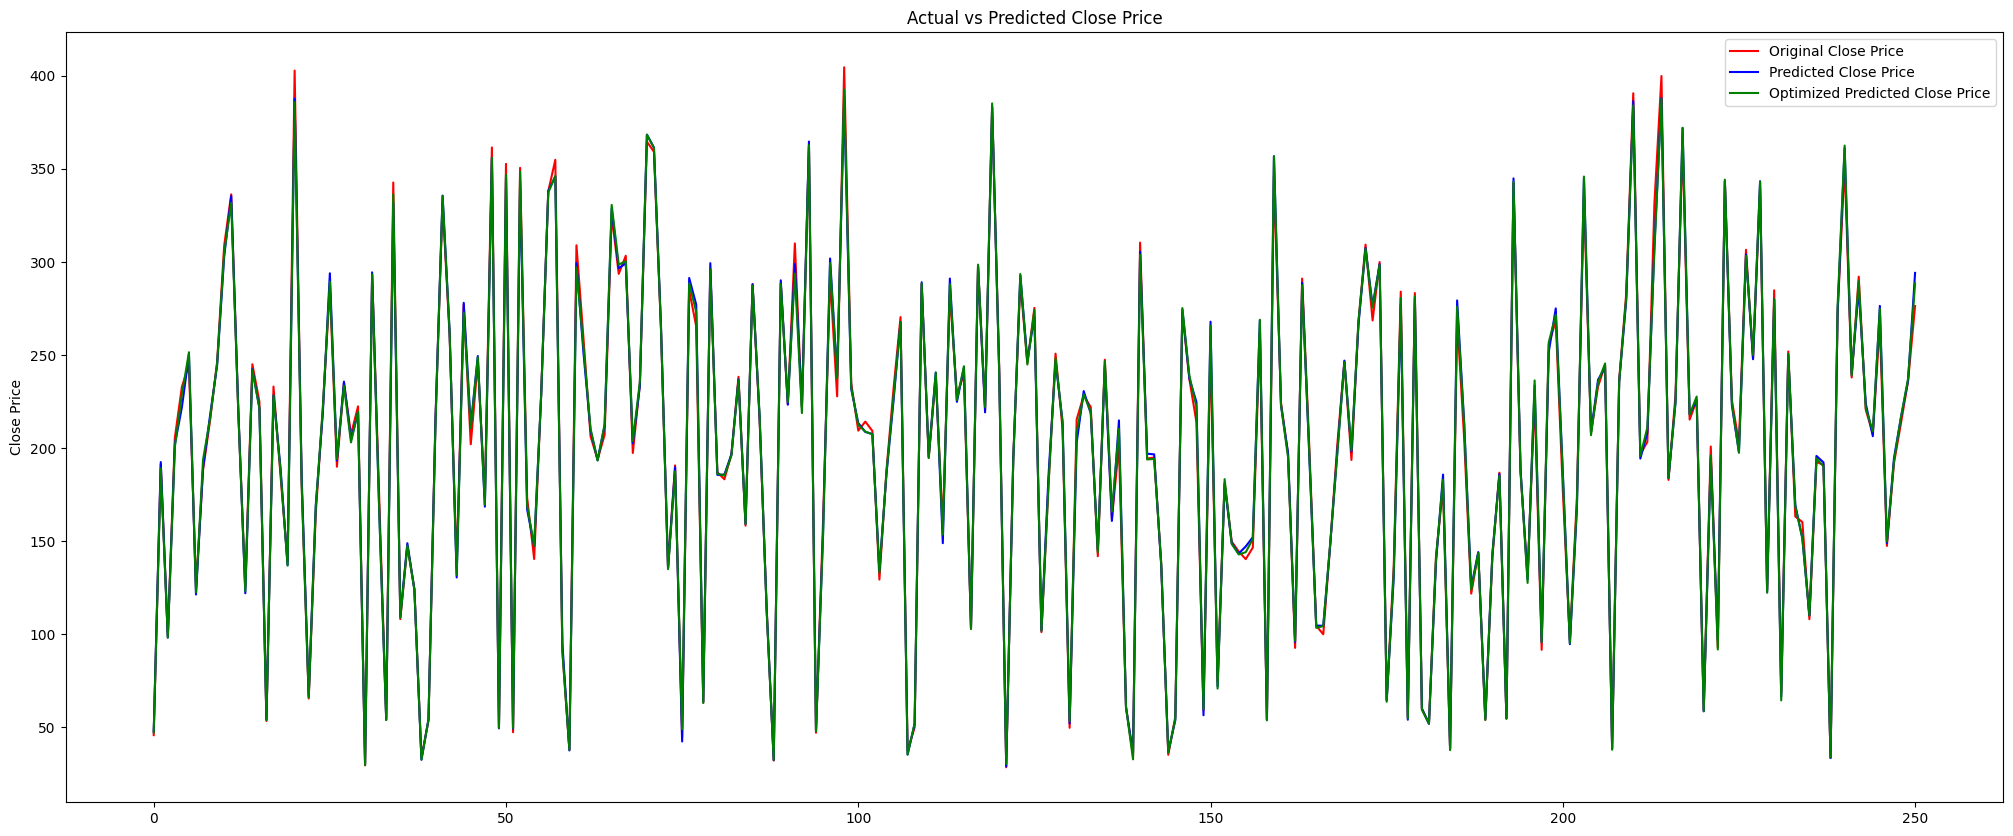

In [73]:
# Plot the line chart
plt.figure(figsize=(25, 10))

plt.plot(merged_df['Adj Close'], color= 'red', label='Original Close Price',)
plt.plot(merged_df['Predicted'], color='blue', label='Predicted Close Price')
plt.plot(merged_df['Optimized Predicted'], color='green', label='Optimized Predicted Close Price')

# Set the labels and title
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

## **Sharp Analysis**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


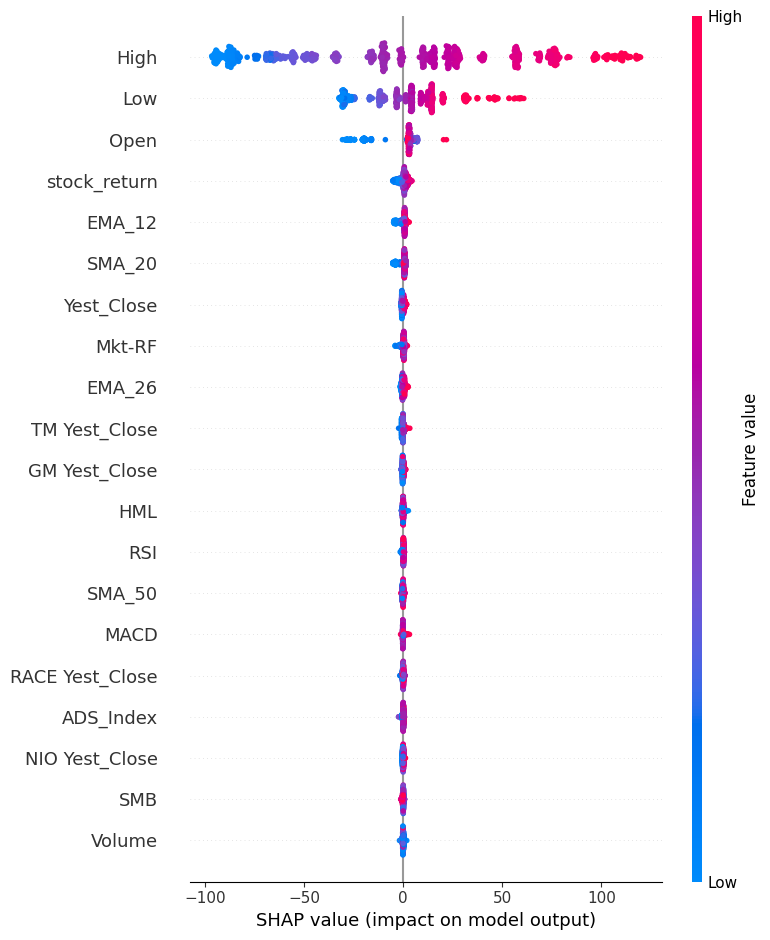

In [74]:
# Create an explainer object
explainer = shap.Explainer(base_model, X)
# Calculate SHAP values
shap_values = explainer.shap_values(X)
# Plot summary plot
shap.summary_plot(shap_values, X)

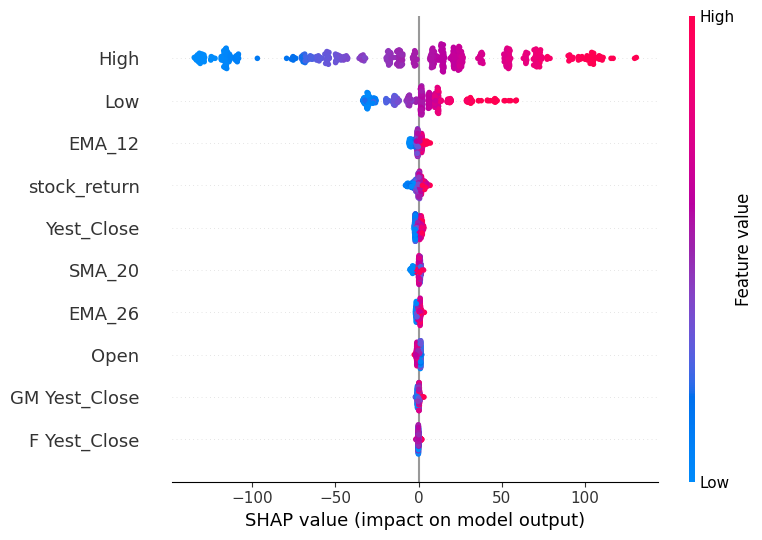

In [75]:
# Create an explainer object
explainer_retrained = shap.Explainer(model_retrained, X_significant_training)
# Calculate SHAP values
shap_values_retrained = explainer_retrained.shap_values(X_significant_training)
# Plot summary plot
shap.summary_plot(shap_values_retrained, X_significant_training)